In [15]:
!pip install transformer_lens circuitsvis

In [2]:
import sys
import torch
from transformers import LlavaProcessor, LlavaForConditionalGeneration
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import circuitsvis as cv
from transformer_lens import HookedTransformer
import gc
import torch.nn.functional as F

2025-05-28 23:06:44.260245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748473604.464149      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748473604.521911      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# --- MODEL LOADING ---
model_id = "llava-hf/llava-1.5-7b-hf"

llava = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    load_in_4bit=False,
    low_cpu_mem_usage=True,
    revision="a272c74",
    device_map="cpu"
)

for param in llava.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [5]:
processor = LlavaProcessor.from_pretrained(model_id, revision="a272c74")
tokenizer = processor.tokenizer

language_model = llava.language_model.eval()
vision_tower = llava.vision_tower.to("cuda:1").eval()
projector = llava.multi_modal_projector.to("cuda:1").eval()

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

In [6]:
hooked_llm = HookedTransformer.from_pretrained(
    "llama-7b-hf",
    center_unembed=False,
    fold_ln=False,
    fold_value_biases=False,
    device="cuda",
    hf_model=language_model,
    tokenizer=tokenizer,
    center_writing_weights=False,
    dtype=torch.float16,
    vocab_size=language_model.config.vocab_size,
)

for param in hooked_llm.parameters():
    param.requires_grad = False

Loaded pretrained model llama-7b-hf into HookedTransformer


In [7]:
# --- HELPER FUNCTIONS ---

def get_llm_input_embeddings(llava, processor, image: Image, text: str, device='cuda:1'):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": text},
                {"type": "image", "image": image},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    print("Prompt:\n", prompt)

    pixel_values = processor.image_processor(image, return_tensors='pt')['pixel_values'].to(device, torch.float16)
    clip_output = llava.vision_tower(pixel_values)
    image_features = llava.multi_modal_projector(clip_output.last_hidden_state)

    input_ids = tokenizer(prompt, return_tensors='pt')['input_ids'].to(device)
    embed_tokens = llava.language_model.model.embed_tokens.to(device)
    text_embeds = embed_tokens(input_ids)

    image_token_id = tokenizer.convert_tokens_to_ids("<image>")
    image_token_indices = (input_ids == image_token_id).nonzero(as_tuple=True)[1]
    if len(image_token_indices) == 0:
        raise ValueError("В prompt не найден токен <image>")

    idx = image_token_indices[0].item()
    text_before = text_embeds[:, :idx, :]
    text_after = text_embeds[:, idx + 1:, :]
    inputs_embeds = torch.cat([text_before, image_features, text_after], dim=1)

    attention_mask = torch.ones(inputs_embeds.shape[:2], dtype=torch.long, device=device)
    position_ids = torch.arange(0, inputs_embeds.shape[1], dtype=torch.long, device=device).unsqueeze(0)

    return inputs_embeds, attention_mask, None, position_ids

In [8]:
def visualize_attention(url):
    # Load image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    question = "What do you see on this photo?"

    # Get embeddings
    inputs_embeds, _, _, _ = get_llm_input_embeddings(llava, processor, image, question, device="cuda:1")

    # Generate response
    with torch.no_grad():
        outputs = hooked_llm.generate(
            inputs_embeds,
            max_new_tokens=30,
            do_sample=True,
            return_type='tokens'
        )
        generated_text = processor.decode(outputs[0], skip_special_tokens=True)
        print("\nGenerated Text:", generated_text)

        gc.collect()
        torch.cuda.empty_cache()

        # Run with cache for attention visualization
        logits, cache = hooked_llm.run_with_cache(inputs_embeds, start_at_layer=23, remove_batch_dim=True)

        # Decode tokens
        product = inputs_embeds @ language_model.model.embed_tokens.weight.T.to("cuda:1")
        llama_str_tokens = hooked_llm.to_str_tokens(product.argmax(dim=-1)[0])

        layers_to_visualize = [23, 28, 31]
        tokens_to_show = 30

        for layer in layers_to_visualize:
            attention_pattern = cache["pattern", layer, "attn"]
            print(f"\nLayer {layer} Head Attention Patterns:")

            display(cv.attention.attention_patterns(
                tokens=llama_str_tokens[-tokens_to_show:],
                attention=attention_pattern[:, -tokens_to_show:, -tokens_to_show:]
            ))

In [9]:
gc.collect()
torch.cuda.empty_cache()

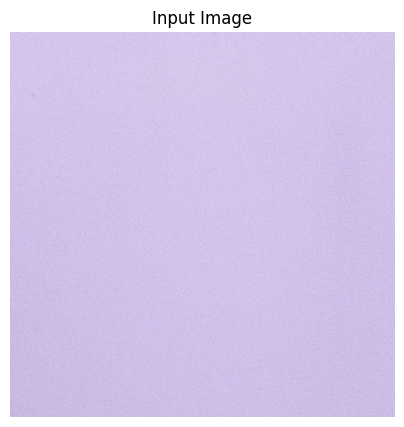

Prompt:
 USER: <image>
What do you see on this photo? ASSISTANT:


  0%|          | 0/30 [00:00<?, ?it/s]


Generated Text: The image displays a blanket of a vivid purple hue that entirely covers the surface in the scene. This purple backdrop contrasts

Layer 23 Head Attention Patterns:



Layer 28 Head Attention Patterns:



Layer 31 Head Attention Patterns:


In [14]:
url = "https://i.pinimg.com/736x/2b/91/29/2b9129cf45f28dc2363a230b7b2069da.jpg"
visualize_attention(url)

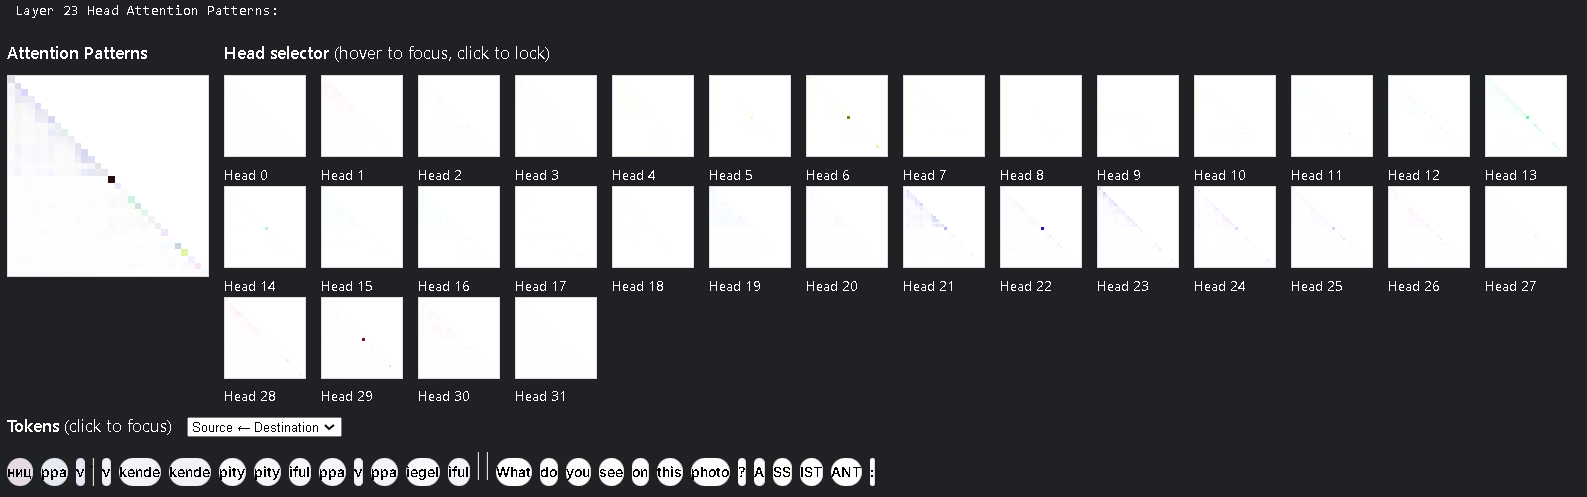

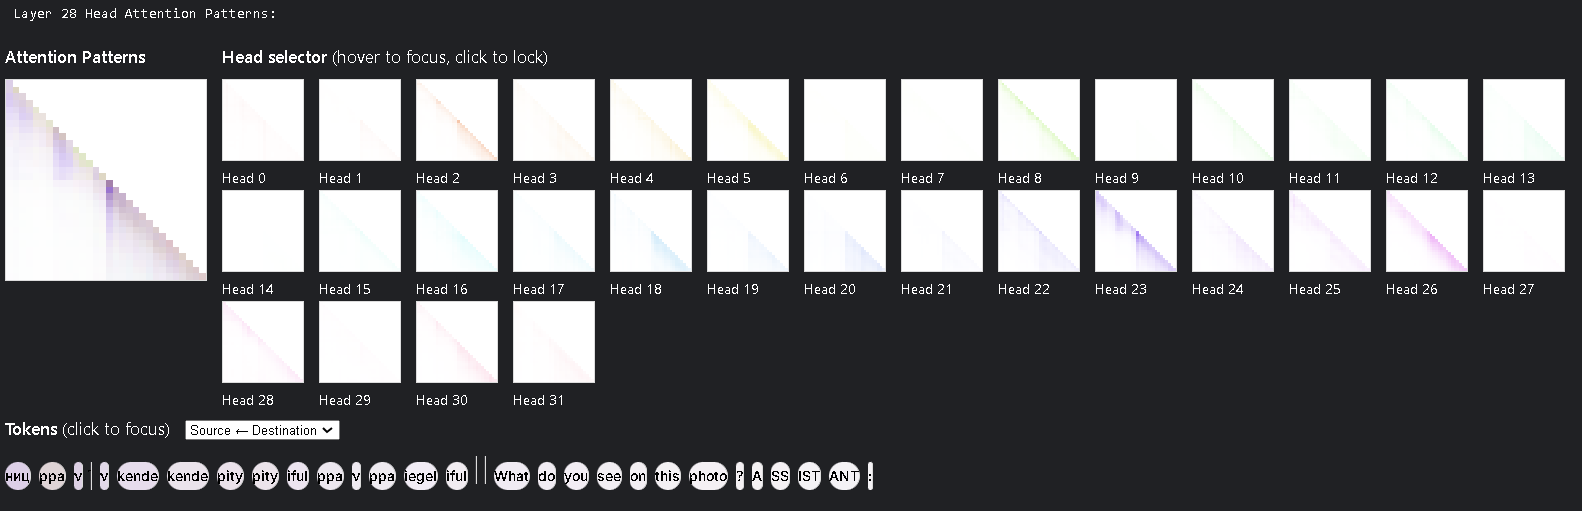

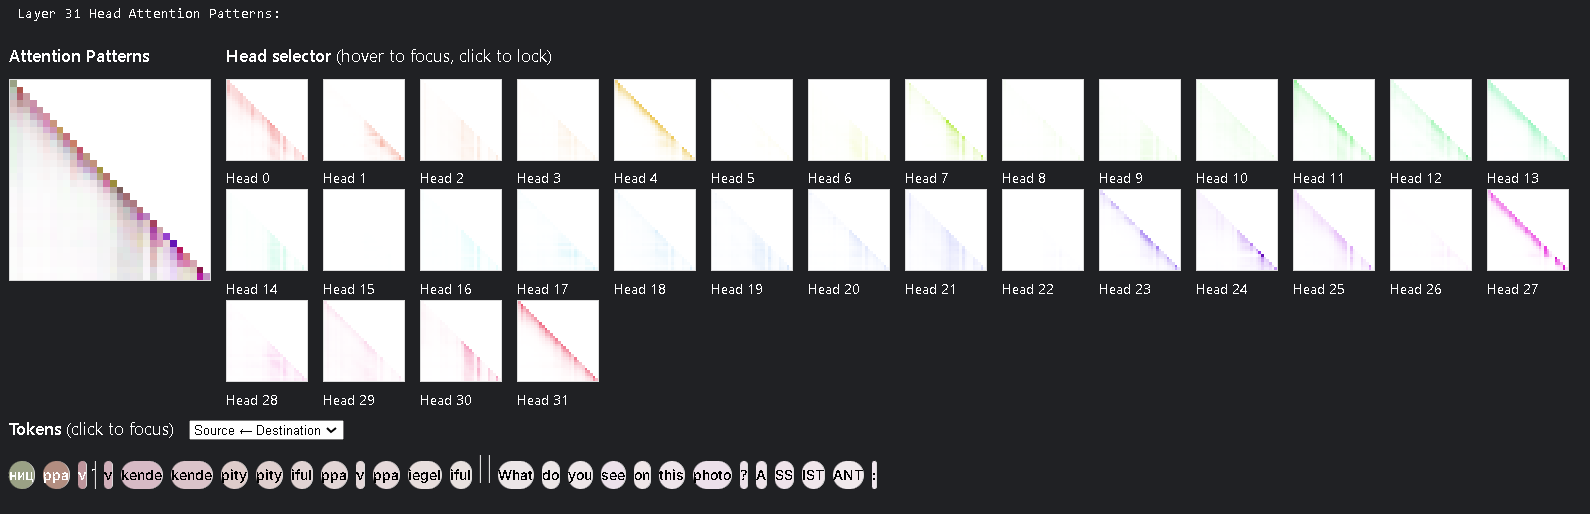

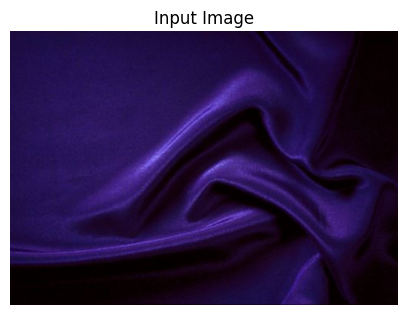

Prompt:
 USER: <image>
What do you see on this photo? ASSISTANT:


  0%|          | 0/30 [00:00<?, ?it/s]


Generated Text: The image features a purple fabric with light and dark purple patterns. The fabric appears to have a silky texture and is displayed from an orient

Layer 23 Head Attention Patterns:



Layer 28 Head Attention Patterns:



Layer 31 Head Attention Patterns:


In [11]:
url = "https://i.pinimg.com/736x/96/df/e9/96dfe96d6a77a9eac20f2e05bcbcd5e3.jpg"
visualize_attention(url)

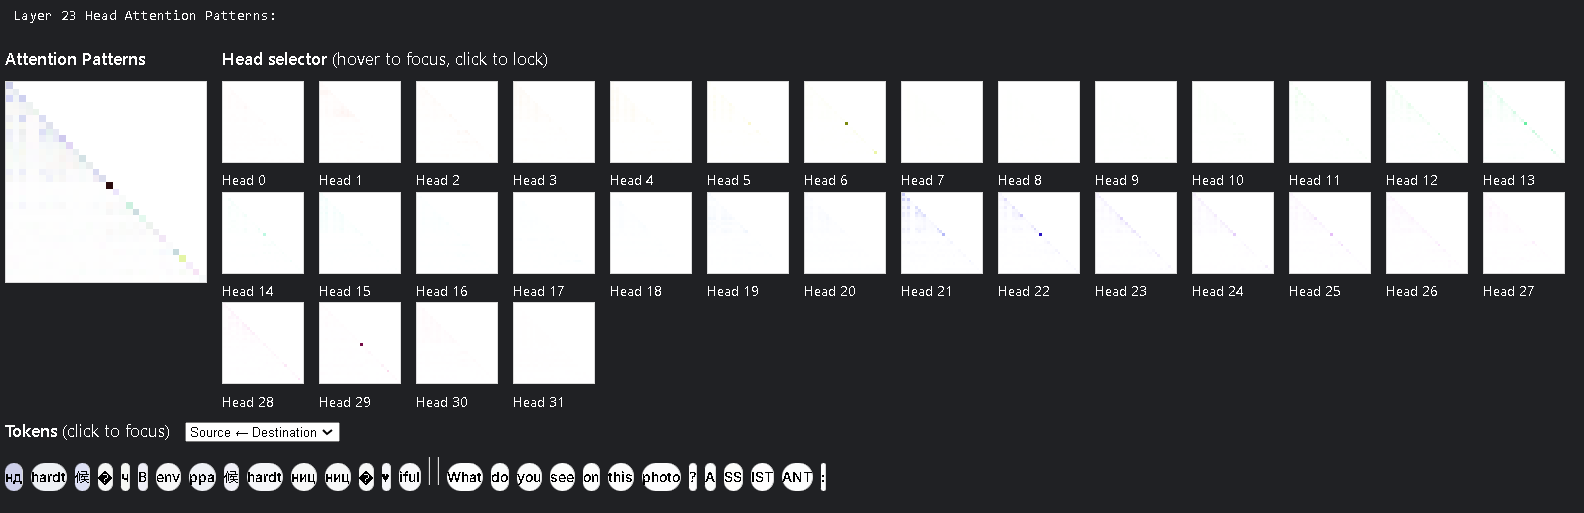

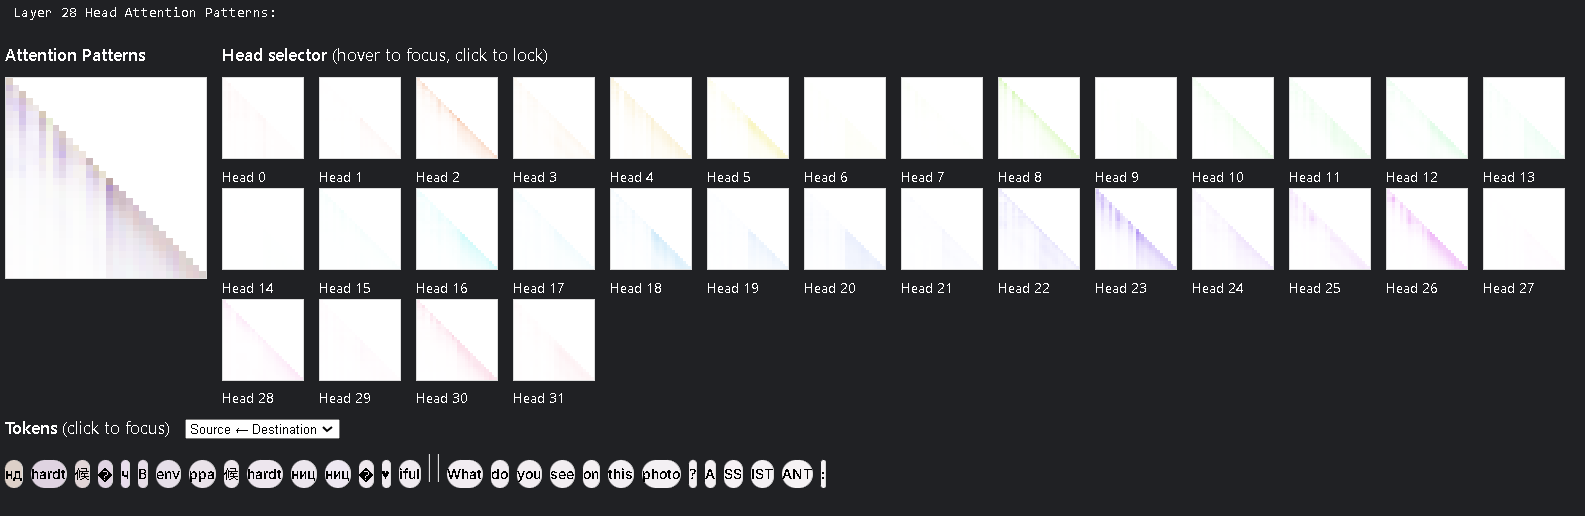

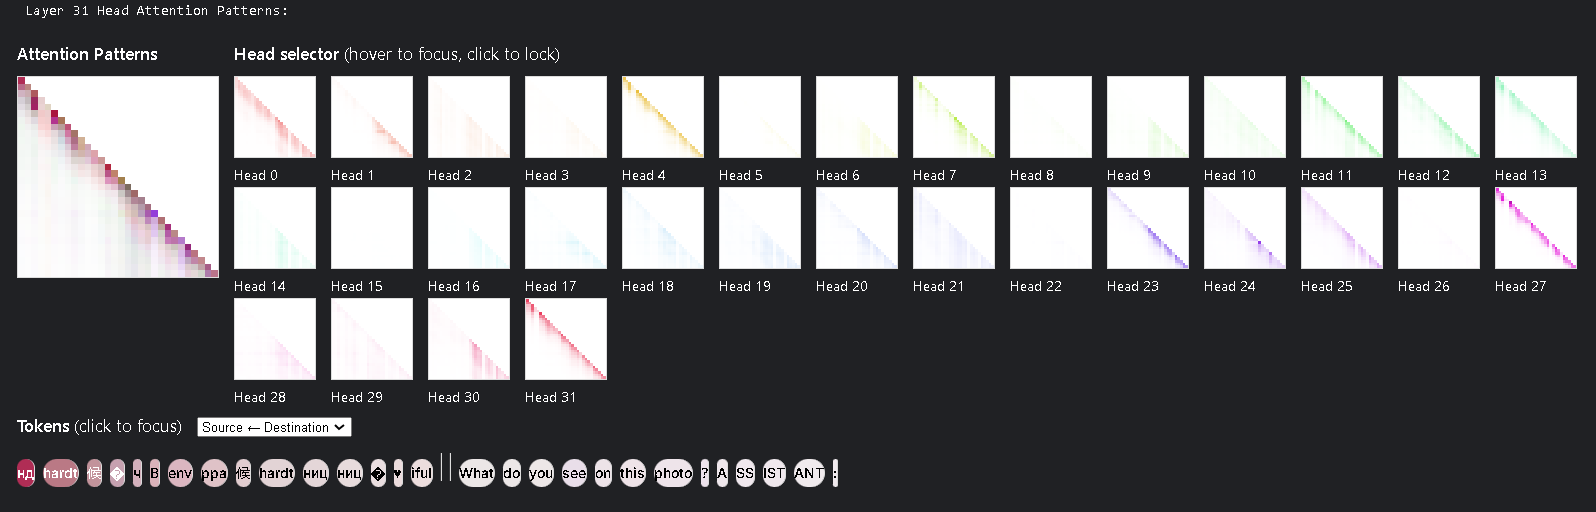

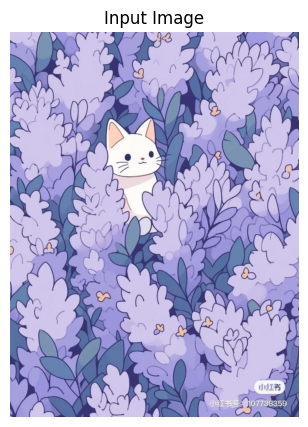

Prompt:
 USER: <image>
What do you see on this photo? ASSISTANT:


  0%|          | 0/30 [00:00<?, ?it/s]


Generated Text: The image features a small, small-celled, toy-like cat standing within a mass of purple flowers. The floral background seems

Layer 23 Head Attention Patterns:



Layer 28 Head Attention Patterns:



Layer 31 Head Attention Patterns:


In [12]:
url = "https://i.pinimg.com/736x/01/f0/0b/01f00baf3337be08c0c58a5b3fc41ecc.jpg"
visualize_attention(url)

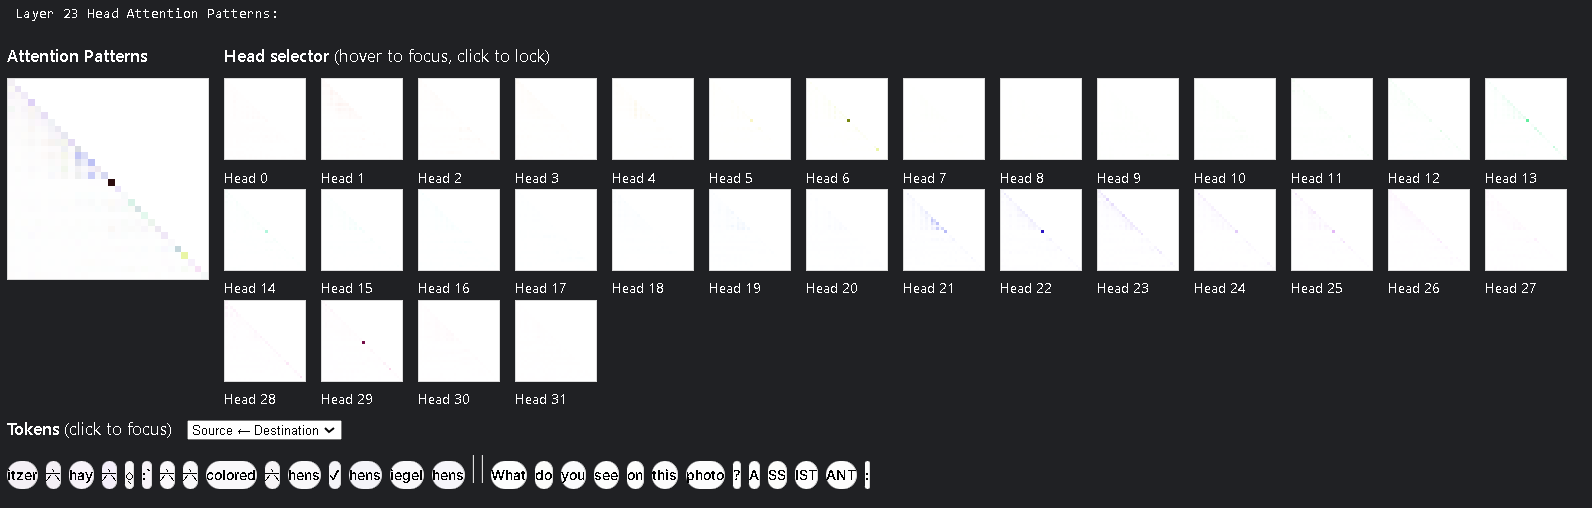

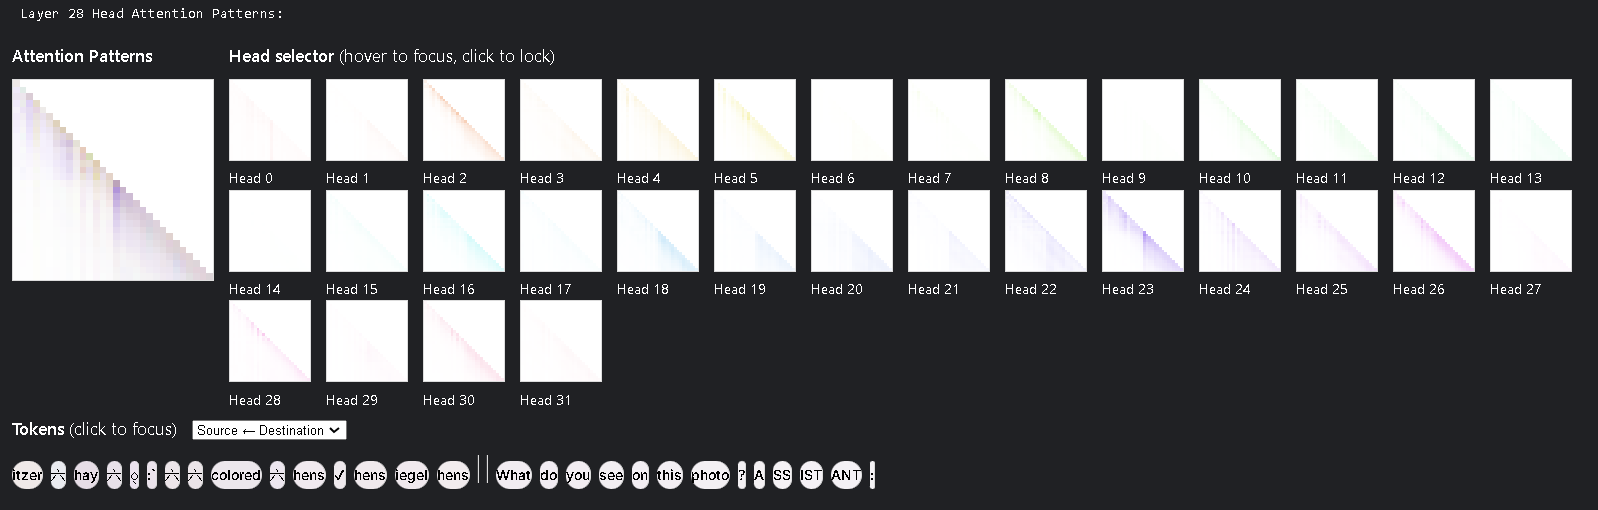

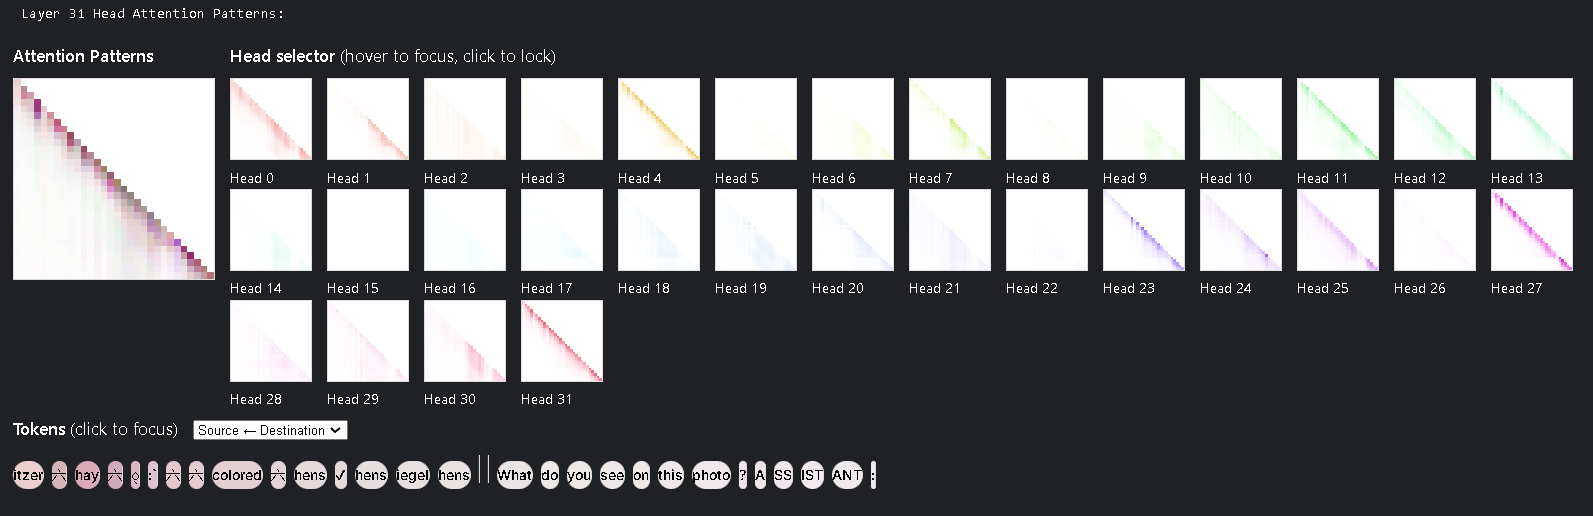

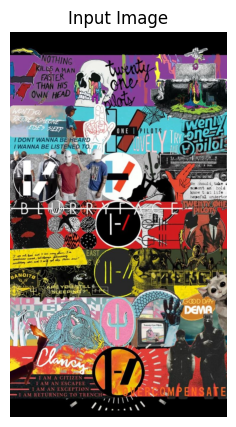

Prompt:
 USER: <image>
What do you see on this photo? ASSISTANT:


  0%|          | 0/30 [00:00<?, ?it/s]


Generated Text: The image is a collage of various images featuring people and bandanas. Within the collage, there is also a collection of stickers displaying words

Layer 23 Head Attention Patterns:



Layer 28 Head Attention Patterns:



Layer 31 Head Attention Patterns:


In [13]:
url = "https://i.pinimg.com/736x/37/ef/f9/37eff97754219d7a5757edd601f37bd9.jpg"
visualize_attention(url)

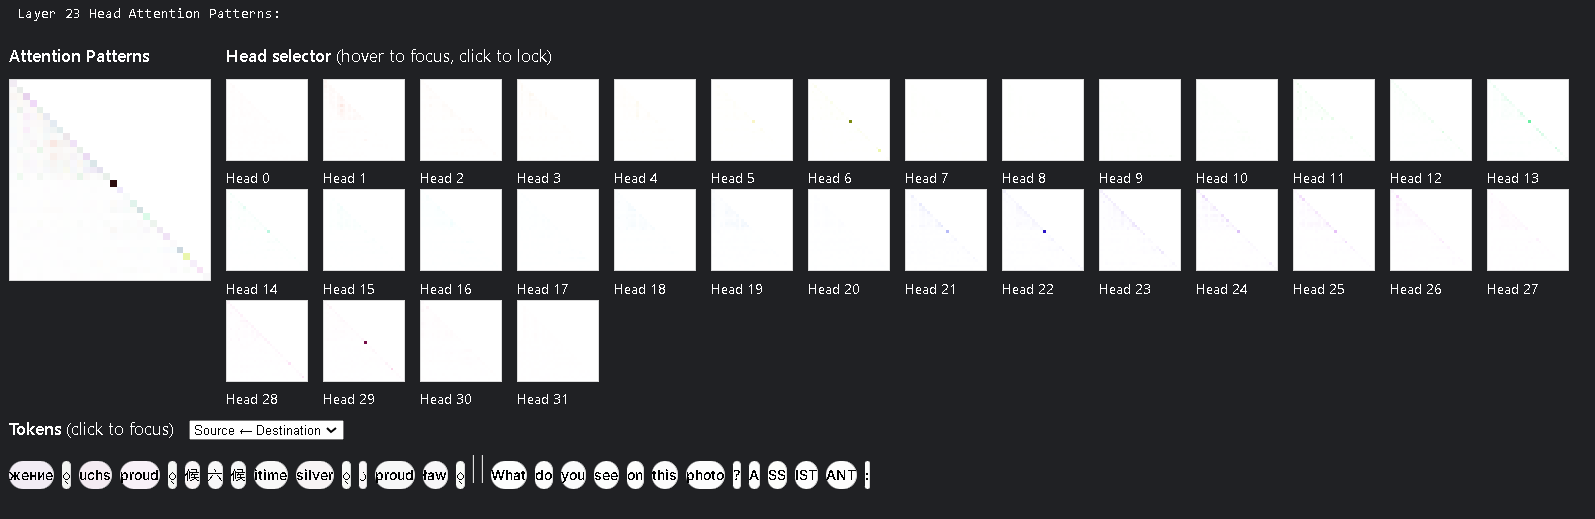

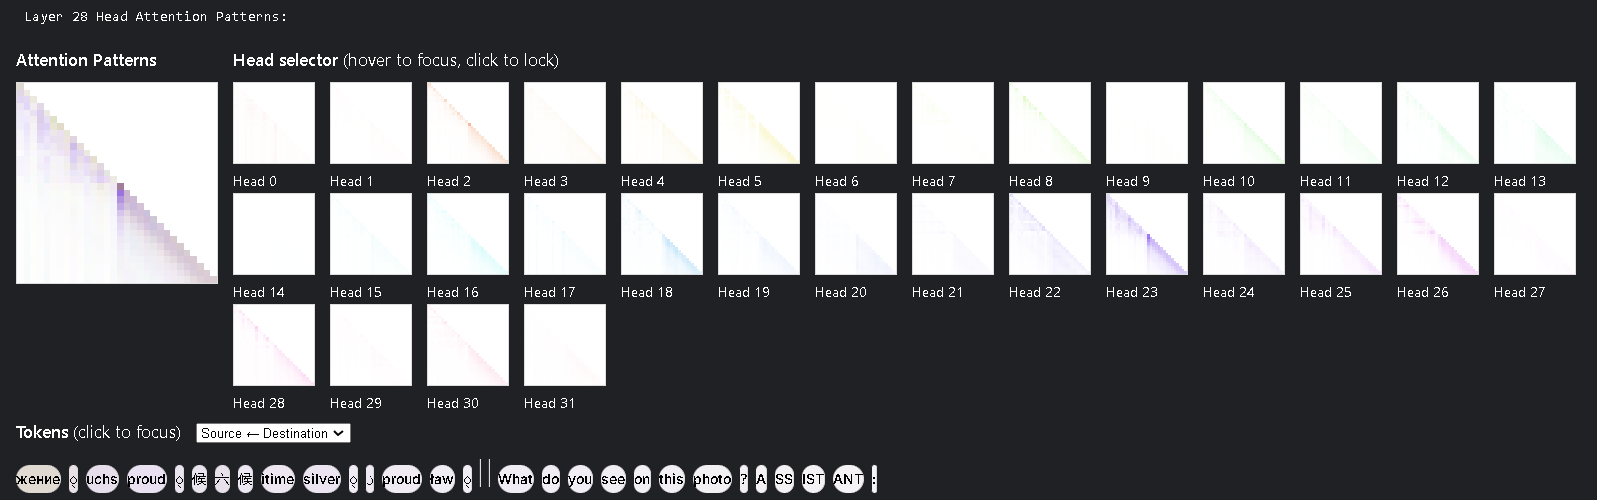

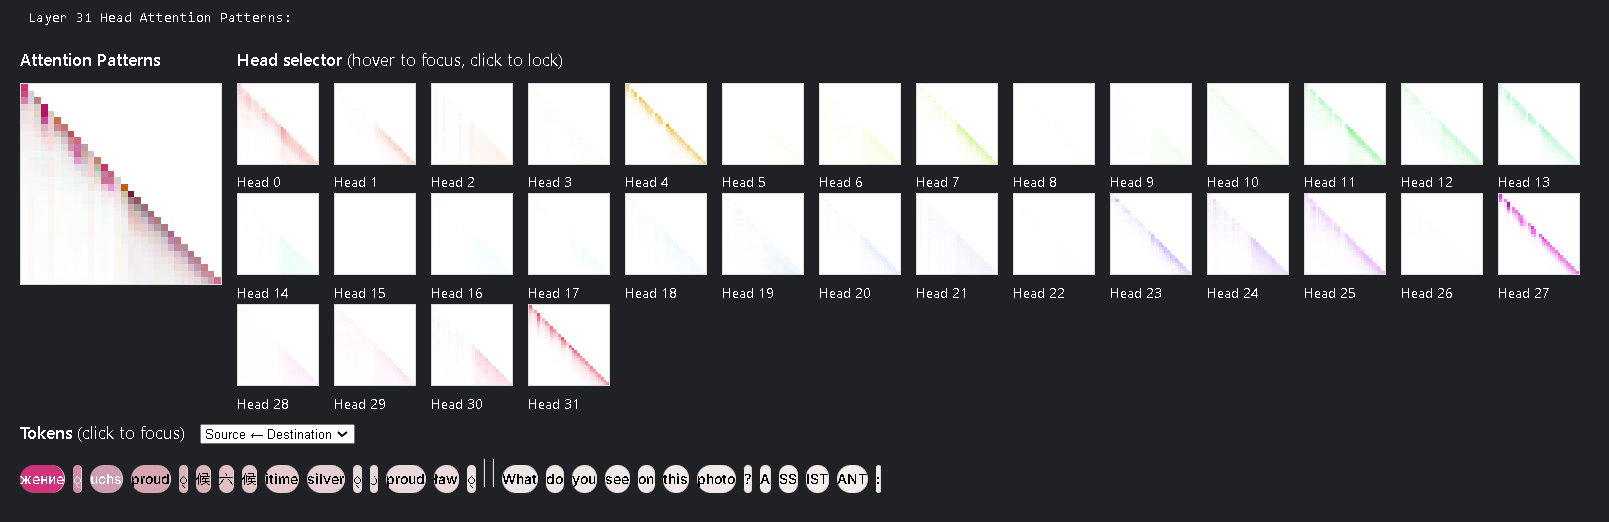